In [1]:
#pip install h5py

In [19]:
import sys, os
import numpy as np
from keras.preprocessing import sequence # for padding
from keras.utils import np_utils # for vectorizing
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.datasets import reuters

### Load dataset

In [20]:
max_features = 20000  # use top `max_features` most common words # max개 이상의 word들은 무시하겠다.
maxlen = 80  # trim after `maxlen` number of words // word padding of trim / sequential dim을 맞춰준다

In [21]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features, test_split=0.2)

In [22]:
# check the structure
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print(x_train)
# index화된 word 데이터가 나온다 # 나중에 실제 data를 쓸때는 word를 index로 변환해서 사용해야된다.

8982 train sequences
2246 test sequences
[list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12])
 list([1, 3267, 699, 3434, 2295, 56, 16784, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 19261, 49, 2295, 13415, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 13415, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])
 list([1, 53, 12, 284, 15, 14, 272, 26, 53, 959, 32, 818, 15, 14, 272, 26, 39, 684, 70, 11, 14, 12, 3886, 18, 180, 183, 187, 70, 11, 14, 102, 32, 11, 29, 53, 44, 704, 15, 14, 19, 758, 15, 53, 959, 47, 1013, 15, 14, 19, 132, 15, 39, 965, 32, 11, 14, 147, 72, 11, 180, 183, 187, 44, 11, 14, 102, 19, 11, 123, 186, 90, 6

In [23]:
# Check labels: 0~45
num_classes = np.max(y_train) + 1
print(num_classes, 'classes')  # 46개의 topic이 있다는 소리이다.

46 classes


### Preprocessing

In [24]:
print('Pad sequences (samples x time)')

Pad sequences (samples x time)


In [25]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

# `pad_sequences` returns a 2d numpy array (num_samples, num_timesteps) 
# `num_timesteps` equals `maxlen`

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 80)
x_test shape: (2246, 80)


In [26]:
# Vectorize labels
print('Convert class vector to binary class matrix (for categorical_crossentropy)')
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Convert class vector to binary class matrix (for categorical_crossentropy)
y_train shape: (8982, 46)
y_test shape: (2246, 46)


In [27]:
y_test[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Commons

In [28]:
# Path to save models // 각 epoch마다 모델 세이브 안하면 나중에 망할 수 도있다.
# save를 위한 path
MODEL_PATH = './reuters_mlp/'
if not os.path.exists(MODEL_PATH):
    os.mkdir(MODEL_PATH)

In [42]:
# Training configuration
max_epochs = 30
batch_size = 128

### 1. Build model

Refer to the [Keras official documentation](https://keras.io/getting-started/sequential-model-guide/)

In [46]:
# y_train shape: (8982, 46)
# y_test shape: (2246, 46)
model = Sequential()
# TODO: YOUR CODE HERE
#단어기 때문에 임베딩을 해줘야함
model.add(Embedding(max_features, 64, input_length=maxlen)) #64 저기는 아무거나 넣어줘도 됨
model.add(Flatten()) # 뒤에 있는애들을 다 곱한만큼
model.add(Dense(256, activation='relu')) #256아무거나 넣어도됨, 여기까지 히든 레이어 하나
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

# the model will take as input an integer matrix of size (batch, input_length).
# the largest integer (i.e. word index) in the input should be no larger than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch dimension.


### 2. Compile model

In [47]:
# TODO: YOUR CODE HERE
from keras import optimizers
adam = optimizers.Adam(lr=0.001, decay=1e-3)

model.compile(optimizer='adam',
             loss = 'categorical_crossentropy',
              metrics=['accuracy']
             )

### 3. Train model
Use early stopping and save your model for later use.

The saved HDF5 file(s) will contain:
1. Model architecture (allows recreation of the model)
2. Weights
3. Training configuration (e.g. loss, optimizer)
4. Optimizer state (allows resuming training from exactly where you left off)

In [48]:
#매 에폭마다 관찰을 할거야 오버피팅이 나오면 굳이 돌릴 필요없잖아
#3회폭까지 수렴이?안되면 멈춰라
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3)

In [49]:
checkpoint = ModelCheckpoint(filepath=os.path.join(MODEL_PATH, '{epoch:02d}-{val_loss:.4f}.h5'),
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True) #베스트만 저장

In [50]:
history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=max_epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpoint])

# delete existing model
del model

Train on 7185 samples, validate on 1797 samples
Epoch 1/30
7185/7185 [==============================] - 3s 414us/step - loss: 2.3423 - acc: 0.4419 - val_loss: 1.7897 - val_acc: 0.5070

Epoch 00001: val_loss improved from inf to 1.78973, saving model to ./reuters_mlp/01-1.7897.h5
Epoch 2/30
7185/7185 [==============================] - 3s 359us/step - loss: 1.4941 - acc: 0.6191 - val_loss: 1.4937 - val_acc: 0.6361

Epoch 00002: val_loss improved from 1.78973 to 1.49367, saving model to ./reuters_mlp/02-1.4937.h5
Epoch 3/30
7185/7185 [==============================] - 2s 339us/step - loss: 0.9428 - acc: 0.7825 - val_loss: 1.3509 - val_acc: 0.6789

Epoch 00003: val_loss improved from 1.49367 to 1.35088, saving model to ./reuters_mlp/03-1.3509.h5
Epoch 4/30
7185/7185 [==============================] - 2s 331us/step - loss: 0.4852 - acc: 0.9062 - val_loss: 1.3722 - val_acc: 0.6745

Epoch 00004: val_loss did not improve from 1.35088
Epoch 5/30
7185/7185 [==============================] - 2s 3

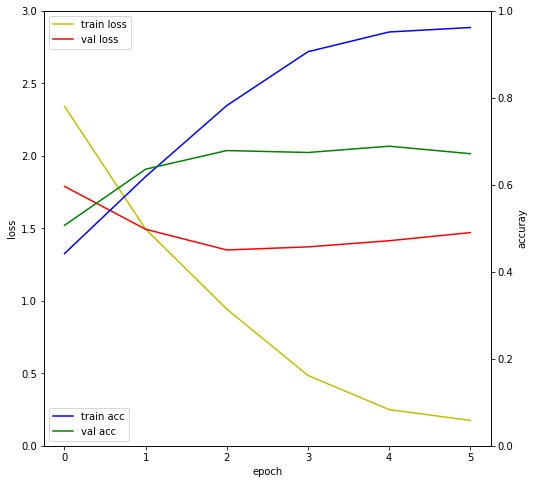

In [51]:
# Visualize training (optional)
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(8,8))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 4. Evaluate model

In [52]:
path = os.path.join(MODEL_PATH, sorted(os.listdir(MODEL_PATH))[-1])
best_model = load_model(path)
loss, acc = best_model.evaluate(x_test, y_test,
                                batch_size=batch_size)

print('----- Evaluation loss and metrics -----')
print('Test loss:', loss)
print('Test accuracy:', acc)

2246/2246 [==============================] - 0s 63us/step
----- Evaluation loss and metrics -----
Test loss: 1.383548496030636
Test accuracy: 0.660730187689101
